# Vehicle Detection and Tracking

Importing the required libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from skimage.feature import hog
import glob
import pickle
from collections import deque

HEAT_MAP_HISTORY = deque(maxlen=10)
HEAT_MAP_HISTORY.clear()

## Defining Required functions

- **get_hog_features** function: This function takes the *image channel*, *orientation*, *pixels per cell*, *cells per block*, *visualisation* and *feature vector* as arguments and return *features vector* and *HOG-image* if *Visualisation* is set to **True** else it only return *features vector*

In [2]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

- **get_hog_test** function: Test the *get_hog_features* function using *car* and *non-car* images

HOG images with Orientation: 12, Pixels per Cell: 8, Cells per Block:2


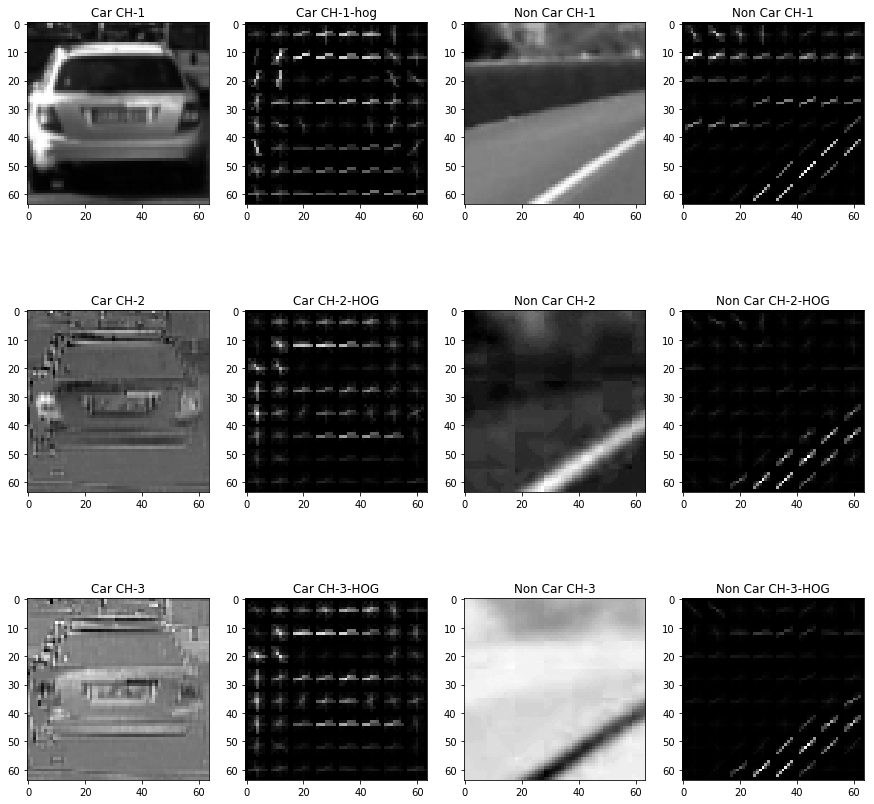

In [63]:
def get_hog_test():
    print('HOG images with Orientation: 12, Pixels per Cell: 8, Cells per Block:2')
    plt.figure(figsize=(15,15))
    # Take a car image and apply HOG
    car_image = mpimg.imread('./test_images/car.png')
    car_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2YCrCb)
    car_image_hog = np.copy(car_image)
    _, car_image_hog[:,:,0] = get_hog_features(car_image_hog[:,:,0],12,8,2,vis=True)
    _, car_image_hog[:,:,1] = get_hog_features(car_image_hog[:,:,1],12,8,2,vis=True)
    _, car_image_hog[:,:,2] = get_hog_features(car_image_hog[:,:,2],12,8,2,vis=True)
    
    # Take a non-car image and apply HOG
    non_car_image = mpimg.imread('./test_images/non_car.png')
    non_car_image = cv2.cvtColor(non_car_image, cv2.COLOR_RGB2YCrCb)
    non_car_image_hog = np.copy(non_car_image)
    _, non_car_image_hog[:,:,0] = get_hog_features(non_car_image_hog[:,:,0],12,8,2,vis=True)
    _, non_car_image_hog[:,:,1] = get_hog_features(non_car_image_hog[:,:,1],12,8,2,vis=True)
    _, non_car_image_hog[:,:,2] = get_hog_features(non_car_image_hog[:,:,2],12,8,2,vis=True)
    
    plt.subplot(3,4,1)
    plt.title('Car CH-1')
    plt.imshow(car_image[:,:,0], cmap='gray')
    
    plt.subplot(3,4,2)
    plt.title('Car CH-1-hog')
    plt.imshow(car_image_hog[:,:,0], cmap='gray')
    
    plt.subplot(3,4,3)
    plt.title('Non Car CH-1')
    plt.imshow(non_car_image[:,:,0], cmap='gray')
    
    plt.subplot(3,4,4)
    plt.title('Non Car CH-1')
    plt.imshow(non_car_image_hog[:,:,0], cmap='gray')
    
    #---
    
    plt.subplot(3,4,5)
    plt.title('Car CH-2')
    plt.imshow(car_image[:,:,1], cmap='gray')
    
    plt.subplot(3,4,6)
    plt.title('Car CH-2-HOG')
    plt.imshow(car_image_hog[:,:,1], cmap='gray')
    
    plt.subplot(3,4,7)
    plt.title('Non Car CH-2')
    plt.imshow(non_car_image[:,:,1], cmap='gray')
    
    plt.subplot(3,4,8)
    plt.title('Non Car CH-2-HOG')
    plt.imshow(non_car_image_hog[:,:,1], cmap='gray')
    
    #---
    
    plt.subplot(3,4,9)
    plt.title('Car CH-3')
    plt.imshow(car_image[:,:,2], cmap='gray')
    
    plt.subplot(3,4,10)
    plt.title('Car CH-3-HOG')
    plt.imshow(car_image_hog[:,:,2], cmap='gray')
    
    plt.subplot(3,4,11)
    plt.title('Non Car CH-3')
    plt.imshow(non_car_image[:,:,2], cmap='gray')
    
    plt.subplot(3,4,12)
    plt.title('Non Car CH-3-HOG')
    plt.imshow(non_car_image_hog[:,:,2], cmap='gray')
    
    plt.show()

get_hog_test()

- **bin_spatial** function: This function takes *image* and *size* (size of bins) as arguments and returns an image that has the appropiate numbers of features required by classifier

In [4]:
def bin_spatial(img, size=(16, 16)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

- **demonstrate_bin_spatial** function: This demonstrates spatial binning of images and their features

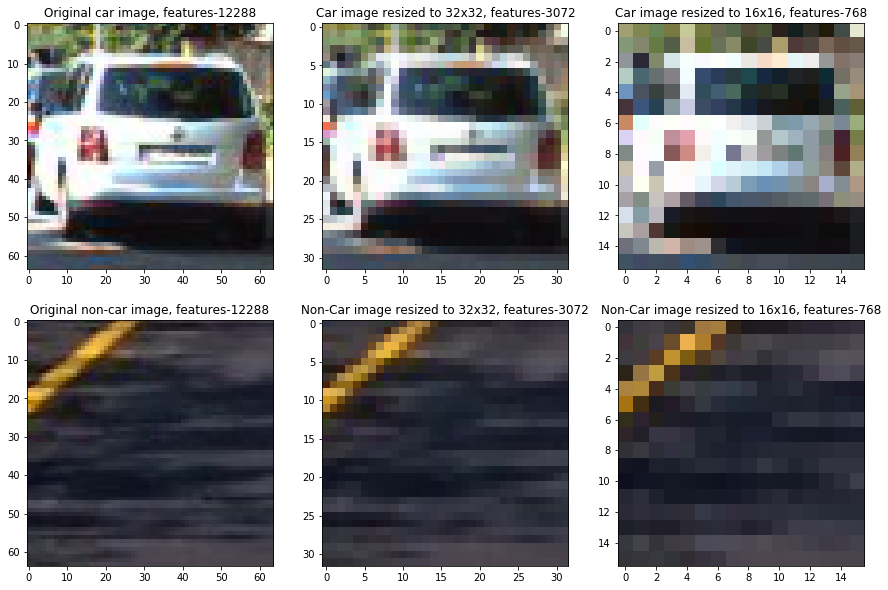

In [5]:
def demonstrate_bin_spatial():
    # Take a car and a non-car image and apply spatial binning
    car_image = mpimg.imread('./test_images/car.jpg')
    non_car_image = mpimg.imread('./test_images/non_car.jpg')
    
    plt.figure(figsize=(15,10))
    plt.subplot(2,3,1)
    plt.imshow(car_image)
    plt.title('Original car image, features-'+ str(len(car_image.ravel())))
    
    plt.subplot(2,3,2)
    car_image_sbin = cv2.resize(car_image, (32,32))
    plt.imshow(car_image_sbin)
    plt.title('Car image resized to 32x32, features-'+ str(len(car_image_sbin.ravel())))
    
    plt.subplot(2,3,3)
    car_image_sbin = cv2.resize(car_image, (16,16))
    plt.imshow(car_image_sbin)
    plt.title('Car image resized to 16x16, features-'+ str(len(car_image_sbin.ravel())))
    
    plt.subplot(2,3,4)
    plt.imshow(non_car_image)
    plt.title('Original non-car image, features-'+ str(len(non_car_image.ravel())))
    
    plt.subplot(2,3,5)
    non_car_image_sbin = cv2.resize(non_car_image, (32,32))
    plt.imshow(non_car_image_sbin)
    plt.title('Non-Car image resized to 32x32, features-'+ str(len(non_car_image_sbin.ravel())))
    
    plt.subplot(2,3,6)
    non_car_image_sbin = cv2.resize(non_car_image, (16,16))
    plt.imshow(non_car_image_sbin)
    plt.title('Non-Car image resized to 16x16, features-'+ str(len(non_car_image_sbin.ravel())))
    
demonstrate_bin_spatial()

- **color_hist** function: This function takes *image*, *number of bins* and *range* as arguments, and returns the histogram features of the image (Horizontally Stacked)

In [6]:
def color_hist(img, nbins=16, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.hstack((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

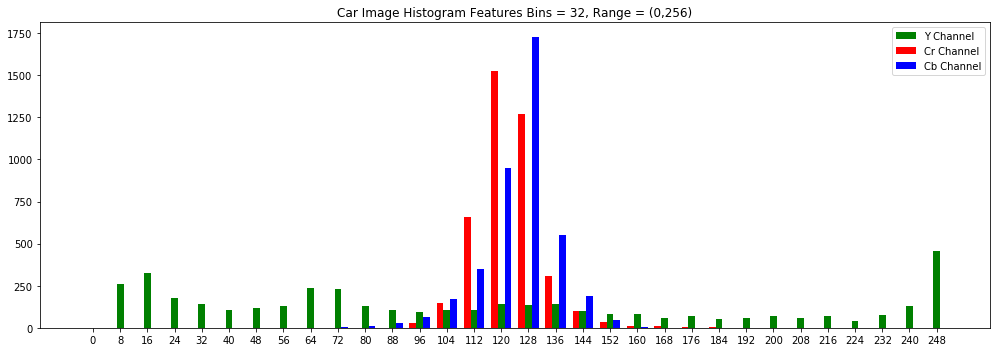

In [7]:
def plot_histogram():
    # Take a car and a non-car image and apply spatial binning
    car_image = mpimg.imread('./test_images/car.jpg')
    non_car_image = mpimg.imread('./test_images/non_car.jpg')
    
    plt.figure(figsize=(14,5))

    plt.title('Car Image Histogram Features Bins = 32, Range = (0,256)')
    
    car_image=cv2.cvtColor(car_image, cv2.COLOR_RGB2YCrCb)
    
    bar_width = 0.25
    Y_hist = np.histogram(car_image[:,:,0], bins=32, range=(0,256))
    Cr_hist = np.histogram(car_image[:,:,1], bins=32, range=(0,256))
    Cb_hist = np.histogram(car_image[:,:,2], bins=32, range=(0,256))
    plt.bar(np.arange(32)+bar_width,Y_hist[0],bar_width,color='g', label='Y Channel')
    plt.bar(np.arange(32),Cr_hist[0],bar_width,color='r', label='Cr Channel')
    plt.bar(np.arange(32)+2*bar_width,Cb_hist[0],bar_width,color='b', label='Cb Channel')
    plt.xticks((np.arange(len(Y_hist[0]))+bar_width),np.int_(Y_hist[1]))
    plt.tight_layout()
    plt.legend()

plot_histogram()

- **extract_features** function: This function takes *image* as a mandatory argument, other arguments like *color-space*, *number of orientations(HOG)*, *pixels per cell*, *cells per block*, *spatial size*, *number of histogram bins* are optional. It extracts all the features regarding **Spatial binning**, **Histogram** and **HOG** and returns the flattened **features vector**

In [8]:
def extract_features(imgs, cspace='RGB', orientations=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_size=(32,32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orientations, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orientations, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features=bin_spatial(feature_image, spatial_size)
        # Apply color_hist() to get color histogram features
        hist_features=color_hist(feature_image, hist_bins)
        
        
        all_features = np.hstack(( spatial_features, hist_features, hog_features))
        # Append the new feature vector to the features list
        features.append(all_features)
    # Return list of feature vectors
    return features

- **train_SVC** function: This function is the main function that trains the **Support Vector Classifier** and saves it in a pickle file. First it takes all the car and non-car images from **KITTI** and **GTI** datasets. Then it extacts the features from the datasets. After that it randomly splits them it test and training datasets. The ratio of this split is 75% as training and 25% as test dataset. The features are also **normalized** after splitting, and the scaler is fit to only training data, but the same scaler is used to normalize both training and test dataset. After that it trains the SVC and also calculates its accuracy using the test dataset. 

In [9]:
from sklearn.svm import SVC
from time import time

def train_SVC():
    # Divide up into cars and notcars
    print('Traing data (image count) -')
    print('KITTI')
    ### KITTI images
    images = glob.glob('./data/kitti/*.png')
    cars = []
    notcars = []
    for image in images:
        if 'image' in image or 'extra' in image:
            notcars.append(image)
        else:
            cars.append(image)
    print('Cars images:', len(cars))
    print('Non-Car images:', len(notcars))

    ### GTI Images
    images = glob.glob('./data/GTI/GTI_Far/*.png')
    print('GTI_far',len(images))
    for image in images:
        cars.append(image)
    images = glob.glob('./data/GTI/GTI_Left/*.png')
    print('GTI_Left',len(images))
    for image in images:
        cars.append(image)
    images = glob.glob('./data/GTI/GTI_Right/*.png')
    print('GTI_Right',len(images))
    for image in images:
        cars.append(image)
    images = glob.glob('./data/GTI/GTI_MiddleClose/*.png')
    print('GTI_MiddleClose',len(images))
    for image in images:
        cars.append(image)
    
    images = glob.glob('./data/GTI/Non_vehicle/*.png')
    print('Non_vehicle',len(images))
    for image in images:
        notcars.append(image)
    

    colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 12
    pix_per_cell = 16
    cell_per_block = 4
    hog_channel = 0 # Can be 0, 1, 2, or "ALL"

    t = time()
    car_features = extract_features(cars, cspace=colorspace, orientations=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    notcar_features = extract_features(notcars, cspace=colorspace, orientations=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    print('Car Features shape',car_features[0].shape)
    t2 = time()
    print(round(t2-t, 2), 'Seconds to extract HOG features...')

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=rand_state)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a non-linear SVC 
    svc = SVC()    
    
    # Check the training time for the SVC
    t=time()
    svc.fit(X_train, y_train)
    t2 = time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t = time()
    n_predict = 20
    print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    
    # Save the model
    with open('svc.pickle','wb') as pickle_file:
        print('Saving SVC in pickle.....')
        pickle.dump({'svc': svc, 'scaler': X_scaler}, pickle_file)
        print('SVC saved.')

- Call  **train_SVC** function

In [ ]:
train_SVC()

- **get_saved_SVC** function: This function loads the saved SVC and the scaler from the pickle file saved earlier during training

In [11]:
def get_saved_SVC():
    print('Loading model....')
    with open('svc.pickle','rb') as pickle_file:
        print('SVC loaded')
        obj = pickle.load(pickle_file)
        return obj[ 'svc' ], obj[ 'scaler' ]

- loading the saved model and scaler to global variables *SVC* and *SCALER*

In [12]:
SVC, SCALER = get_saved_SVC()

Loading model....
SVC loaded


- **add_heat** function: This function takes *heatmap* and *bounding box cordinates* as arguments and adds +1 (increases heat) of all the pixels in the *heatmap* which fall within the pairs of *bounding box cordinates*

In [13]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

- **apply_threshold** function: This function takes *heatmap* and *heat threshold* as arguments and then nullifies the heat (sets pixel value to zero) of the pixels whose value is below the particular *heat threshold*

In [14]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

- **draw_labeled_bboxes** function: Takes *image* and *label* array as arguments and draws rectangular boxes around the cars in the image denoted by the *label* array

In [15]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img

- **hot2rgb** function: Takes a *heatmap image* as an argument and return the corresponding *rgb image*

In [16]:
def hot2rgb( heatmap ):
    min_value, max_value = np.amin(heatmap), np.amax(heatmap)
    normalized_hm = ( heatmap - min_value ) / ( max_value - min_value )
    cmap = plt.get_cmap('hot')
    rgba = cmap(normalized_hm) * 255
    
    r,g,b = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2]
    return np.dstack((r,g,b))

- **find_cars** function: This is the main function of the pipeline. It takes arguments such as *image*, *starting y-coordinate*, *stopping y-coordinate*, *scaling factor*, *svc*, *scaler*, *orientations*, *pixels per cell*, *cells per block* etc. extracts all the features from the image and returns the an image with a rectangle drawn around the detected car, along with the *bounding box coordinates*

In [59]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    box_list = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    red = np.random.randint(1,200)
    green = np.random.randint(100,250)
    for xb in range(nxsteps):
        ypos = 0 #since scaling factor along y will always be 1
        xpos = xb*cells_per_step
        # Extract HOG for this patch
        hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 

        hog_features = np.hstack((hog_feat1))

        xleft = xpos*pix_per_cell
        ytop = ypos*pix_per_cell

        # Extract the image patch
        subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

        # Get color features
        spatial_features = bin_spatial(subimg, size=spatial_size)
        hist_features = color_hist(subimg, nbins=hist_bins)

        # Scale features and make a prediction
        test_features = X_scaler.transform(np.hstack(( spatial_features, hist_features, hog_features)).reshape(1, -1))    
        #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
        test_prediction = svc.predict(test_features)

        if test_prediction == 1:
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),7) 
            box_list.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
            
        cv2.rectangle(draw_img,(np.int(xleft*scale), np.int(ytop*scale)+ystart),(np.int(xleft*scale)+np.int(window*scale),np.int(ytop*scale)+np.int(window*scale)+ystart),(red,green,0),3)
    
    return draw_img, box_list

- **pipeline** function: This function takes an *image* argument, sends to *find_cars* function, gets the *bounding box* coordinates around the car(s). It then creates the heatmap according to the bounding box coordinates and also the history recorded by last 10 frames and finally returns the images with *bounding boxes* drawn and also the *heat map*

In [18]:
from scipy.ndimage.measurements import label

def pipeline(img):
    
    global HEAT_MAP_HISTORY
    
    svc = SVC
    X_scaler = SCALER
    orient = 12
    pix_per_cell = 16
    cell_per_block = 4
    spatial_size = (32,32)
    hist_bins = 32
    
    ystart_list = [400,400, 410, 410, 420, 430]
    ystop_list = [464,480, 506, 538, 580, 610]
    scale_list = [64/64, 80/64, 96/64, 128/64, 160/64, 180/64]

    heat_map = np.zeros_like(img[:,:,0]).astype(np.float)
    heat_map_with_history = np.zeros_like(img[:,:,0]).astype(np.float)
    for ystart, ystop, scale in zip(ystart_list,ystop_list,scale_list):
        out_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        heat_map = add_heat(heat_map,box_list)
#         plt.figure(figsize=(15,10))
#         plt.subplot(1,2,1)
#         plt.imshow(out_img)
#         plt.subplot(1,2,2)
#         plt.imshow(heat_map, cmap='hot')

    # Heat map history
    HEAT_MAP_HISTORY.append(apply_threshold(heat_map,1))
    
    for h_map in HEAT_MAP_HISTORY:
        heat_map_with_history += np.array(h_map)
        
        
    
    # Clip heat_map_with_history    
    heat_map_with_history = np.clip(heat_map_with_history, 0, 255)
    
    #Apply Threshold
    heat_map_with_history = apply_threshold(heat_map_with_history, min(len(HEAT_MAP_HISTORY), 10))
    
    # Find final boxes from heatmap using label function
    labels = label(heat_map_with_history)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img, heat_map_with_history


- **process_clip** function: This function takes a single frame from the video, processes the frame and returns the processed frame containing the *heatmap* in top-right corner

In [28]:
def process_clip(image):
    result, heatmap = pipeline( image )
#     plt.figure(figsize=(15,10))
    
#     plt.subplot(1,2,1)
#     plt.imshow( heatmap, cmap='hot' )
    
#     plt.subplot(1,2,2)
#     plt.imshow( result )
    
    heatmap = cv2.resize(heatmap,None,fx=0.25,fy=0.25,interpolation = cv2.INTER_AREA)
    rgb_img = hot2rgb(heatmap)
    result[:int(result.shape[0]*0.25),int(result.shape[1]*0.75):result.shape[1] ] = result[:int(result.shape[0]*0.25),int(result.shape[1]*0.75):result.shape[1] ]*0.3 + 0.7*rgb_img
    return result

- Testing **process_clip()** with a single test image

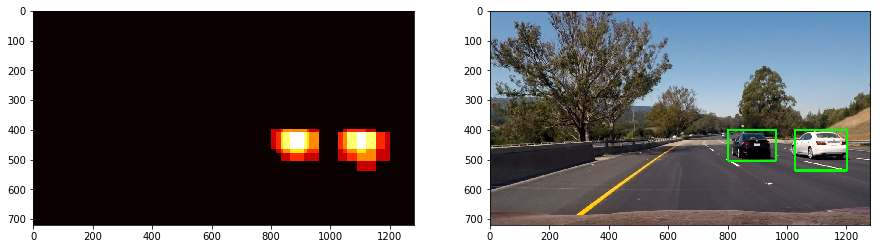

In [26]:
HEAT_MAP_HISTORY.clear()
image = plt.imread('./test_images/test6.jpg')
image = process_clip(image)
plt.figure()
# plt.imshow(image)
plt.show()

- Testing **process_clip()** with all images present in the ./test_images folder

C:\Users\Arindam Baidya\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Arindam Baidya\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\matplotlib\colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


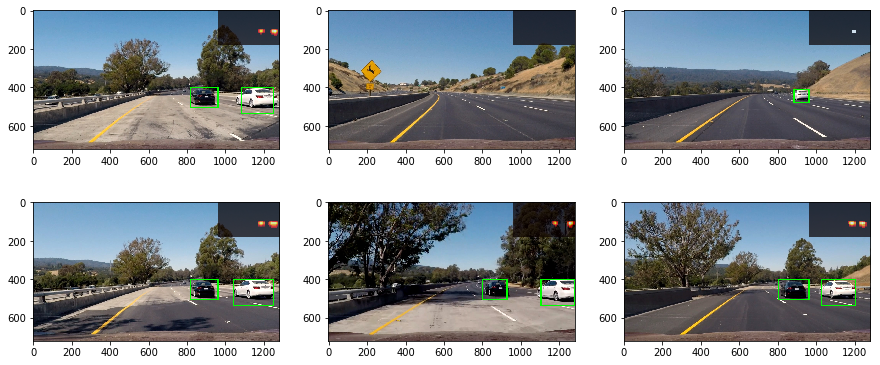

In [31]:
images = glob.glob('./test_images/t*.jpg')
plt.figure(figsize=(15,10))
i=1
for imagepath in images:
    HEAT_MAP_HISTORY.clear()
    image = mpimg.imread(imagepath)
    image = process_clip(image)
    plt.subplot(3,3,i)
    plt.imshow(image)
    plt.imsave('./output_images/test'+str(i)+'.jpg', image)
    i+=1
plt.show()

## Build the video 

In [21]:
from moviepy.editor import VideoFileClip

def make_video(destination_path, source_path):
    global HEAT_MAP_HISTORY
    HEAT_MAP_HISTORY.clear()
    ##clip1 = VideoFileClip("project_video.mp4").subclip(39,43)
    clip1 = VideoFileClip(source_path).subclip(22,25)
    lane_clip = clip1.fl_image(process_clip)
    %time lane_clip.write_videofile(destination_path, audio=False)

In [22]:
make_video('output_video/project_video_small.mp4', 'project_video.mp4')

[MoviePy] >>>> Building video output_video/project_video_small.mp4
[MoviePy] Writing video output_video/project_video_small.mp4


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 75/76 [02:17<00:01,  1.91s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video_small.mp4 

Wall time: 2min 19s


## Preview Video

In [64]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output_video/project_video.mp4'))

# Testing (Debugging Purposes)

(64, 64, 3)
(3072,) (96,) (192,)
[1.]


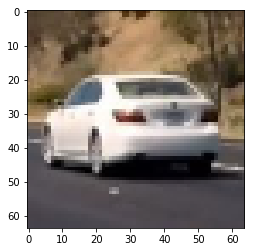

In [24]:
def testing():
    svc = SVC
    X_scaler = SCALER
    image = mpimg.imread('./test_images/MyTest.jpg')
    image = cv2.resize(image,(64,64))
    print(image.shape)
    plt.imshow(image)
    spatial_features = bin_spatial(image, size=(32,32))
    hist_features = color_hist(image, nbins=32)
    hog_features1 = get_hog_features(image[:,:,0], 12, 16, 4, feature_vec=False).ravel()
    hog_features = np.hstack((hog_features1))
    
    print( spatial_features.shape, hist_features.shape, hog_features.shape)
    # Scale features and make a prediction
    test_features = X_scaler.transform(np.hstack(( spatial_features, hist_features, hog_features)).reshape(1, -1))    
    #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
    test_prediction = svc.predict(test_features)
    print(test_prediction)

testing()

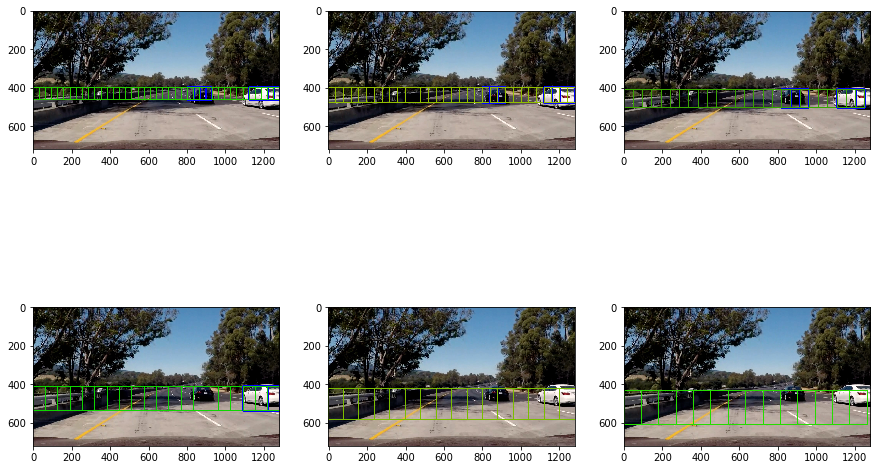

In [62]:
def testing2():
    
    img = plt.imread('./test_images/test5.jpg')
    
    svc = SVC
    X_scaler = SCALER
    orient = 12
    pix_per_cell = 16
    cell_per_block = 4
    spatial_size = (32,32)
    hist_bins = 32
    
    ystart_list = [400,400, 410, 410, 420, 430]
    ystop_list = [464,480, 506, 538, 580, 610]
    scale_list = [64/64, 80/64, 96/64, 128/64, 160/64, 180/64]

    plt.figure(figsize=(15,10))
    
    i=1
    heat_map = np.zeros_like(img[:,:,0]).astype(np.float)
    heat_map_with_history = np.zeros_like(img[:,:,0]).astype(np.float)
    all_out_img = np.zeros_like(img)
    for ystart, ystop, scale in zip(ystart_list,ystop_list,scale_list):
        out_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        plt.subplot(2,3,i)
        plt.imshow(out_img)
        plt.imsave('./output_images/sliding_window'+str(i)+'.jpg', out_img)
        i+=1

testing2()